# The Effect of Ethnicity on American School Districts

Leo Suber

## Introduction

The main purpose of this project is to be a tutorial to walk you through the data science pipeline, but I wanted to also use this as an opportunity to prove something about a hotly debated topic at the moment.

Poverty is a major topic in the United States and this is heavily influenced by education. If you can't get a good education, then you can't get a good job, so you can't get much money, so your children can't get a good education either because schools are paid for by property tax and an area with a bad schooling system does not have a high land value. It's just a vicious cycle that makes it nearly impossible to succeed in later life if you weren't born into a upper or middle-class family. The concept of getting a good education leading to a good job and more opportunities is so common that it has lost all meaning to me.

The idea that every system in the United States is built upon some discriminatory policy leading to inherent inequality across all parts of the United States is also being talked about a lot when this project was being made. I absolutely agree with this, but I wanted to quantify just how bad the effects of this are.

## Hypothesis

The greater percentage of white people there are in a given school distrcit, the more resources the school has. If you ask almost anyone at the University of Maryland, they will say that this should be the null hypothesis, but if you ask someone like Tucker Carlson, they would probably say the exact opposite. I want to make it completely clear that ethnic inequality still exists in the United States, so I will treat the idea that there is no inequality as the null hypothesis and that the education quality positively correlates with the percentage of white people in a school district as the alternative hypothesis. This sets a higher bar for my statistics to reach and, therefore, will set a precedent for any argument against this project in particular.

## Data Collection

The first part of the data pipeline is data collection, and to do that, we need to import some libraries.

In [ ]:
# Installing things.
%pip install pyreadstat
%pip install plotly

# Importing a lot of things from sklearn.
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn

# Importing various other necessary libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import pyreadstat
import scipy.stats
import statsmodels.formula.api
import statsmodels.api

# Importing a few things from plotly and initializing things when necessary.
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

Next, we have to read the data from the dataset into the program itself. To do this, we will use Pandas' read_csv method to convert the CSV files that this data comes in into two Pandas DataFrames.

In [2]:
# Reading the information from the datasets into Pandas DataFrames for use
# in this project.
school_df = pd.read_csv("Public_School_Characteristics_2019-20.csv", low_memory=False)
poverty_df = pd.read_csv("School_Neighborhood_Poverty_Estimates_2019-20.csv", low_memory=False)

Now we have two different datasets with one of them having almost 80 variables. However, most of those variables don't contain data that is relevant to this project, so we can just not include those in the DataFrames that we are actually going to use.

In [3]:
# Splitting the existing DataFrames into the pieces that are pertinent.
poverty_pieces = [poverty_df.iloc[:, 3:4], poverty_df.iloc[:, 8:10]]
school_pieces = [school_df.iloc[:, 2:3], school_df.iloc[:, 4:5], school_df.iloc[:, 18:20], school_df.iloc[:, 37:38],
                      school_df.iloc[:, 39:45], school_df.iloc[:, 50:51], school_df.iloc[:, 75:76]]

We will also merge the datasets for easier comparison. We will do this based on each school's unique ID (its value for NCESSCH). I will also change the names of the variables because they are very confusing right now. During this project I will be measuring the income-poverty estimate, student-teacher ratio, virtual learning accessibility, and lunch program eligibility of any given school district. Speaking of these terms, I will have to explain what they actually mean:

* The income-poverty estimate is slightly counterintuitive. The lower the ratio is, the more impoverished a family or area is.
* The student-teacher ratio is self-explanatory.
* The virtual learning accessibility is essentially a boolean value, where a school district either does or does not have access to virtual learning (since this data was taken from 2019-2020, virtual learning is pretty important).
* The lunch program eligibility is how many students in a school district are eligible for either a reduced price and free school lunch.

In [4]:
# Putting the DataFrame pieces back together and then sorting them by their unique school ID.
poverty_df = pd.concat(poverty_pieces, axis=1)
poverty_df = poverty_df.sort_values(by='NCESSCH').reset_index(drop=True)
school_df = pd.concat(school_pieces, axis=1)
school_df = school_df.sort_values(by='NCESSCH').reset_index(drop=True)

df_2019 = pd.merge(poverty_df, school_df, how="inner")

df_2019 = df_2019.rename(columns = {'NCESSCH': 'ID', 'IPR_EST': 'Income_Poverty_Estimate', 'STABR': 'State_Code', 'IPR_SE': 'Income_Poverty_StdDev',
                                    'VIRTUAL': 'Virtual', 'TOTFRL': 'Lunch_Program_Elig', 'TOTAL': 'Total_Students', 'AM': 'Native_American',
                                    'HI': 'Hispanic', 'BL': 'Black', 'WH': 'White', 'HP': 'Hawaiian_and_Pacific', 'TR': 'Mixed',
                                    'STUTERATIO': 'Student_Teacher_Ratio'})

# I don't know why Asian was one of the last variables in the dataset, but I decided to move it closer to the other
# demographic-related variables to make it easier.
df_2019.insert(12, 'Asian', df_2019.pop('AS'))

df_2019.head()

,ID,Income_Poverty_Estimate,Income_Poverty_StdDev,State_Code,Virtual,Lunch_Program_Elig,Total_Students,Native_American,Hispanic,Black,White,Hawaiian_and_Pacific,Asian,Mixed,Student_Teacher_Ratio
0,10000500870,270,115,AL,Not Virtual,608,861,1,455,28,351,0,3,23,20.500000
1,10000500871,337,141,AL,Not Virtual,901,1554,3,732,61,711,0,8,39,19.425000
2,10000500879,180,101,AL,Not Virtual,649,908,4,457,30,378,1,3,35,22.146341
3,10000500889,218,86,AL,Not Virtual,706,934,4,523,29,352,0,3,23,18.495050
4,10000501616,425,123,AL,Not Virtual,384,607,3,325,30,230,0,3,16,20.931034


Statistics like "how many students are eligibile for lunch programs" will obviously vary with the total number of students. So, an effective way of making the total number of students irrelevant in a relationship like this would be to measure by percentages of students. In this case, I will be tracking the percentage of students in a given school that are NOT white.

In [5]:
# Creating a new column for the percentage of non-white students in a given school district.
df_2019['Non_White'] = df_2019['Total_Students'] - df_2019['White']
df_2019['Non_White_Percent'] = (df_2019['Non_White'] / df_2019['Total_Students']) * 100
df_2019.head()

,ID,Income_Poverty_Estimate,Income_Poverty_StdDev,State_Code,Virtual,Lunch_Program_Elig,Total_Students,Native_American,Hispanic,Black,White,Hawaiian_and_Pacific,Asian,Mixed,Student_Teacher_Ratio,Non_White,Non_White_Percent
0,10000500870,270,115,AL,Not Virtual,608,861,1,455,28,351,0,3,23,20.500000,510,59.233449
1,10000500871,337,141,AL,Not Virtual,901,1554,3,732,61,711,0,8,39,19.425000,843,54.247104
2,10000500879,180,101,AL,Not Virtual,649,908,4,457,30,378,1,3,35,22.146341,530,58.370044
3,10000500889,218,86,AL,Not Virtual,706,934,4,523,29,352,0,3,23,18.495050,582,62.312634
4,10000501616,425,123,AL,Not Virtual,384,607,3,325,30,230,0,3,16,20.931034,377,62.108731


Now, we can just plot a graph with a line of best fit and that should show a clear relationship!

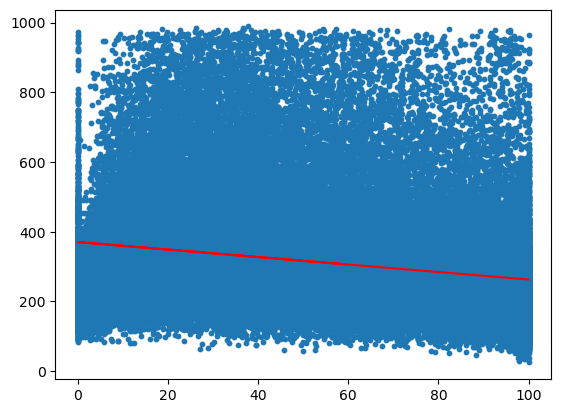

In [6]:
# Plotting a graph with all of the data points and a line of best fit.
df_2019_temp = df_2019.dropna(subset = "Non_White_Percent")
slope, intercept = np.polyfit(df_2019_temp['Non_White_Percent'], df_2019_temp['Income_Poverty_Estimate'], 1)
plt.scatter(df_2019_temp['Non_White_Percent'], df_2019_temp['Income_Poverty_Estimate'], s=10)
plt.plot(df_2019_temp['Non_White_Percent'], slope * df_2019_temp['Non_White_Percent'] + intercept, color="red")

Or not... maybe plotting data from 99,512 different schools and expecting to see much more than a Big Blue Box™ didn't make much sense. To prevent something like the above graph from happening again, I will be comparing different mean values of various variables.

## Data Processing

We can't really see a trend when there are that many data points, so we will have to cut down the number a bit while still keeping the data as accurate as possible so we don't end up coming to the wrong conclusion.

To reduce the load, I will round all of the Non_White_Percent values down to create another variable called "Rounded_NWP" (which stands for "rounded non-white percent") and plot the mean values of each of those points. This way, I will only have to plot 101 data points rather than almost 100,000 data points.

In [7]:
df_2019['Non_White_Percent'] = df_2019['Non_White'] / df_2019['Total_Students'] * 100
df_2019['Rounded_NWP'] = df_2019['Non_White_Percent']
df_2019 = df_2019.round({'Rounded_NWP': 0})
df_2019.head()

,ID,Income_Poverty_Estimate,Income_Poverty_StdDev,State_Code,Virtual,Lunch_Program_Elig,Total_Students,Native_American,Hispanic,Black,White,Hawaiian_and_Pacific,Asian,Mixed,Student_Teacher_Ratio,Non_White,Non_White_Percent,Rounded_NWP
0,10000500870,270,115,AL,Not Virtual,608,861,1,455,28,351,0,3,23,20.500000,510,59.233449,59.0
1,10000500871,337,141,AL,Not Virtual,901,1554,3,732,61,711,0,8,39,19.425000,843,54.247104,54.0
2,10000500879,180,101,AL,Not Virtual,649,908,4,457,30,378,1,3,35,22.146341,530,58.370044,58.0
3,10000500889,218,86,AL,Not Virtual,706,934,4,523,29,352,0,3,23,18.495050,582,62.312634,62.0
4,10000501616,425,123,AL,Not Virtual,384,607,3,325,30,230,0,3,16,20.931034,377,62.108731,62.0


It isn't shown above, but there is still some missing data to take care of. Some of these data points have almost no data at all. About 1,500 of them either do not have the total number of students in their school during 2019-2020 on record, or their information quality is so bad that it could not be used for the dataset that I am using. If a school doesn't even keep track of its total number of students, then they probably don't know the ethnic makeup of their student population, which is what I'm looking for. In cases like these, where there is very minimal data about the given schools, it would be hard to figure out anything else about the school, so I will have to remove those schools from the dataset.

In [8]:
df_2019 = df_2019[df_2019['Total_Students'] > 0].reset_index(drop=True)
df_2019 = df_2019[df_2019['Student_Teacher_Ratio'] > 0].reset_index(drop=True)

In the dataset that I used, virtual learning is split up into more categories than just "virtual", "non-virtual", and "I don't know", but I don't need to know anything more specific than what I just said, so I will combine these options into the categorical values I stated previously. 0 is no virtual learning, 1 is some amount of virtual learning, and NaN is an unknown amount of virtual learning.

In [9]:
# Converting the missing values in various columns to N/A to make replacement easier.
df_2019['Virtual'] = df_2019['Virtual'].replace("(Not Virtual)", 0, regex=True)
df_2019['Virtual'] = df_2019['Virtual'].replace("(Virtual)|(Supplemental Virtual)|(Full Virtual)|(Virtual with face to face options)", 1, regex=True)
df_2019['Virtual'] = df_2019['Virtual'].replace("(M)|(N)", np.nan, regex=True)

holder = df_2019.copy()

There will also be a few problems posed by missing values in lunch program eligibility and remote learning accessibility, but I don't have a way to figure those out from the data I have, so I will have to remove them for the time being. We will come back to those schools later.

In [10]:
# Removing all of the schools that do not have data on the lunch program eligibility or
# remote learning accessbility.
small_df = df_2019[df_2019['Lunch_Program_Elig'] >= 0].reset_index(drop=True)
small_df = df_2019.dropna(how="any", subset={"Lunch_Program_Elig", "Virtual"}).reset_index(drop=True)

## Exploratory Analysis and Data Visualization

If we want to find a relationship for ourselves, it is best to create a visual representation of the data. Some scatter plots with mean percentages of non-white students in a school district should work. A line of best fit would also help to make some of these plots more comprehensible.

I will graph the relationships of a school district's income-poverty estimate, student-teacher ratio, remote learning accessibility, and lunch program eligibility vs. the number of non-white students and total students in that school district.

In [11]:
# I am creating a function for this so it can be used in other places.
def graph_relations(in_df):
    # Creating dataframes for the mean and standard deviation of each of the percentages of non-white
    # students for the variables listed above.
    ipe_mean_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Income_Poverty_Estimate']].mean()
    ipe_std_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Income_Poverty_Estimate']].std()
    str_mean_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Student_Teacher_Ratio']].mean()
    str_std_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Student_Teacher_Ratio']].std()
    vir_mean_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Virtual']].mean()
    vir_std_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Virtual']].std()
    lpep_mean_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Lunch_Program_Elig']].mean()
    lpep_std_df = in_df.groupby('Rounded_NWP')[['Rounded_NWP', 'Lunch_Program_Elig']].std()

    # Creating some more Pandas Series to use shortly.
    standard_ipe = pd.Series(float)
    standard_str = pd.Series(float)
    standard_vir = pd.Series(float)
    standard_lpep = pd.Series(float)
    i = 0

    # A loop that goes through each of the previously listed variables and standardizes them by
    # multiplying the value by the variable mean and dividing it by the standard deviation.
    while i <= 100:
        standard_ipe[i] = (ipe_mean_df['Income_Poverty_Estimate'][i] - ipe_mean_df['Income_Poverty_Estimate'].mean()) / ipe_std_df['Income_Poverty_Estimate'][i]
        standard_str[i] = (str_mean_df['Student_Teacher_Ratio'][i] - str_mean_df['Student_Teacher_Ratio'].mean()) / str_std_df['Student_Teacher_Ratio'][i]
        standard_vir[i] = (vir_mean_df['Virtual'][i] - vir_mean_df['Virtual'].mean()) / vir_std_df['Virtual'][i]
        standard_lpep[i] = (lpep_mean_df['Lunch_Program_Elig'][i] - lpep_mean_df['Lunch_Program_Elig'].mean()) / lpep_std_df['Lunch_Program_Elig'][i]
        i = i + 1

    # Scattering the plot.
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
    fig.get_axes()[0].scatter(ipe_mean_df['Rounded_NWP'], standard_ipe)
    fig.get_axes()[1].scatter(str_mean_df['Rounded_NWP'], standard_str)
    fig.get_axes()[2].scatter(vir_mean_df['Rounded_NWP'], standard_vir)
    fig.get_axes()[3].scatter(lpep_mean_df['Rounded_NWP'], standard_lpep)

    # Creating a Dictionary of the Pandas Series's of means from before to use as the x-axes
    # on the scatter plots that are going to be created.
    x = {}
    x[0] = ipe_mean_df['Rounded_NWP'].array.reshape(-1,1)
    x[1] = str_mean_df['Rounded_NWP'].array.reshape(-1,1)
    x[2] = vir_mean_df['Rounded_NWP'].array.reshape(-1,1)
    x[3] = lpep_mean_df['Rounded_NWP'].array.reshape(-1,1)

    # Creating a Dictionary of the Pandas Series's of standardized values from before to use
    # as the y-axes on the scatter plots that are going to be created.
    y = {}
    y[0] = standard_ipe
    y[1] = standard_str
    y[2] = standard_vir
    y[3] = standard_lpep

    # Creating lines of best fit using linear regression for each of the scatter plots. Then,
    # the lines of best fit are plotted on the same plot as the scatter plot.
    reg = {}
    for i in range(4):
        reg[i] = linear_model.LinearRegression()
        reg[i].fit(x[i], y[i])
        fig.get_axes()[i].plot(x[i], reg[i].coef_*x[i] + reg[i].intercept_, color="red")

    # Just titling each of the scatter plots.
    axs[0,0].set_title("Standardized Income-Poverty Estimate vs.\nPercentage of Non-White Students")
    axs[0,1].set_title("Standardized Student-Teacher Ratio vs.\nPercentage of Non-White Students")
    axs[1,0].set_title("Standardized Remote Learning Accessibility vs.\nPercentage of Non-White Students")
    axs[1,1].set_title("Standardized Lunch Program Eligibility vs.\nPercentage of Non-White Students")

    # Just labeling the axes of each of the scatter plots.
    axs[0,0].set(xlabel="Percentage of Non-White Students", ylabel="Standardized Income-Poverty\nEstimate")
    axs[0,1].set(xlabel="Percentage of Non-White Students", ylabel="Standardized Student-Teacher\nRatio")
    axs[1,0].set(xlabel="Percentage of Non-White Students", ylabel="Standardized Remote Learning\nAccessibility")
    axs[1,1].set(xlabel="Percentage of Non-White Students", ylabel="Standardized Lunch Program\nEligibility")

    fig.show()

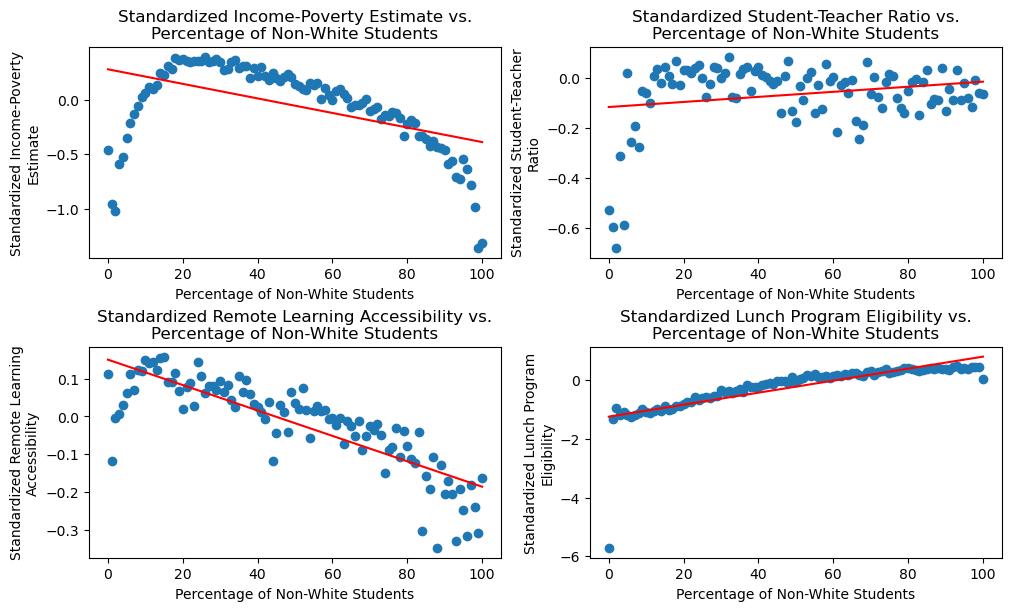

In [12]:
# Actually graphing the relationships.
graph_relations(small_df)

It looks like there is absolutely a correlation for all of these plots, but some are more significantly correlated than others. The lunch program eligibility is ABSOLUTELY positively correlated with the percentage of non-white students in an area. The income-poverty estimate is negatively correlated with the percentage of non-white students, along with the remote learning accessibility, although that one is less significant. Finally, the student-teacher ratio appears to have a very slight positive correlation with the percentage of non-white students.

However, just because we can see a correlation doesn't mean that it is statistically significant. To determine that, we will have to look at the p-value of each of the different relationships.

For this, we can use the entire dataset again since we don't need to look at a graph. We can still figure out about how accurate the line of best fit on these graphs would be r^2 value of each relationship.

In [13]:
# Creating a Dictionary of models between the percentage of non-white students and the variables
# being measured.
temp_model = {}
temp_model[0] = statsmodels.formula.api.ols(formula="Income_Poverty_Estimate ~ Non_White_Percent", data=small_df).fit()
temp_model[1] = statsmodels.formula.api.ols(formula="Student_Teacher_Ratio ~ Non_White_Percent", data=small_df).fit()
temp_model[2] = statsmodels.formula.api.ols(formula="Virtual ~ Non_White_Percent", data=small_df).fit()
temp_model[3] = statsmodels.formula.api.ols(formula="Lunch_Program_Elig ~ Non_White_Percent", data=small_df).fit()

# Printing the p-values and r^2 values of each of the models created above.
print("Income-Poverty Estimate p-value:", temp_model[0].pvalues[1], "\t\t\tIncome-Poverty Estimate r^2 score:", temp_model[0].rsquared)
print("Student-Teacher Ratio p-value:", temp_model[1].pvalues[1], "\tStudent-Teacher Ratio r^2 score:", temp_model[1].rsquared)
print("Virtual Accessibility p-value:", temp_model[2].pvalues[1], "\tVirtual Accessibility r^2 score:", temp_model[2].rsquared)
print("Lunch Program Eligibility p-value:", temp_model[3].pvalues[1], "\t\t\tLunch Program Eligibility r^2 score:", temp_model[3].rsquared)

Income-Poverty Estimate p-value: 0.0 			Income-Poverty Estimate r^2 score: 0.04724670952676868
Student-Teacher Ratio p-value: 0.36112422963093804 	Student-Teacher Ratio r^2 score: 1.1356875606494121e-05
Virtual Accessibility p-value: 8.127718684554529e-149 	Virtual Accessibility r^2 score: 0.009150014928136607
Lunch Program Eligibility p-value: 0.0 			Lunch Program Eligibility r^2 score: 0.1597031745070968


The p-values say that there is almost certainly a correlation between income-poverty estimates, virtual accessbility, lunch program eligibility and the percentage of non-white students in a school. The reason the r^2 values are so low is because of how large the sample size is. As was demonstrated by the Big Blue box with almost 100,000 data points, it is nearly impossible to create a line of best fit for something with that large of a sample size.

That being said, what if we wanted to know group out of these is the most disadvantaged in the previous relationships? (I won't include student-teacher ratio because ethnicity did not have a significant relationship with it).

In [14]:
# This is a function designed to obtain the percentage of students of each ethnicity from this
# found in the DataFrame in_df.
def get_percent_df(in_df):
    percent_df = in_df.copy()

    # Creating a Pandas DataFrame that contains the percentage of each listed ethnicity for a
    # given school district.
    percent_df['Native_American_Per'] = (percent_df['Native_American'] / percent_df['Total_Students']) * 100
    percent_df['Hispanic_Per'] = (percent_df['Hispanic'] / percent_df['Total_Students']) * 100
    percent_df['Black_Per'] = (percent_df['Black'] / percent_df['Total_Students']) * 100
    percent_df['White_Per'] = (percent_df['White'] / percent_df['Total_Students']) * 100
    percent_df['Hawaiian_and_Pacific_Per'] = (percent_df['Hawaiian_and_Pacific'] / percent_df['Total_Students']) * 100
    percent_df['Asian_Per'] = (percent_df['Asian'] / percent_df['Total_Students']) * 100
    percent_df['Mixed_Per'] = (percent_df['Mixed'] / percent_df['Total_Students']) * 100

    # Reusing the columns for the amounts of students of a given ethnicity in a given school
    # district for rounded percentages.
    percent_df['Native_American'] = (percent_df['Native_American'] / percent_df['Total_Students']) * 100
    percent_df['Hispanic'] = (percent_df['Hispanic'] / percent_df['Total_Students']) * 100
    percent_df['Black'] = (percent_df['Black'] / percent_df['Total_Students']) * 100
    percent_df['White'] = (percent_df['White'] / percent_df['Total_Students']) * 100
    percent_df['Hawaiian_and_Pacific'] = (percent_df['Hawaiian_and_Pacific'] / percent_df['Total_Students']) * 100
    percent_df['Asian'] = (percent_df['Asian'] / percent_df['Total_Students']) * 100
    percent_df['Mixed'] = (percent_df['Mixed'] / percent_df['Total_Students']) * 100
    percent_df = percent_df.round({'Native_American':0, 'Hispanic':0, 'Black':0, 'White':0, 'Hawaiian_and_Pacific':0, 'Asian':0, 'Mixed':0})

    return(percent_df)

In [15]:
# Forewarning, this may be some of the worst-looking code that I have ever written, but I added comments so
# it is at least somewhat comprehensible.

# This function standardizes the percentages of students from a given school district that are of a certain
# ethnicity.
def graph_eth_relations(percent_df):
    # Creating lists that will be used to envoke the names of columns in temp_df.
    column_arr = ["Native_American", "Hispanic", "Black", "White", "Hawaiian_and_Pacific", "Asian", "Mixed"]
    column_per_arr = ["Native_American_Per", "Hispanic_Per", "Black_Per", "White_Per", "Hawaiian_and_Pacific_Per", "Asian_Per", "Mixed_Per"]

    # Creating all of the dictionaries before assigning values to them. 
    ipe_mean = {}
    ipe_std = {}
    vir_mean = {}
    vir_std = {}
    lpep_mean = {}
    lpep_std = {}

    # A loop that goes through temp_df and assigns the mean income-poverty estimate, virtual instruction
    # accessibility, and lunch program eligibility to all entries in the dictionaries above, while also
    # assigning an ethnicity to each separate entry.
    i = 0
    for i in range(7):
        ipe_mean[i] = percent_df.groupby(column_arr[i])[[column_per_arr[i], 'Income_Poverty_Estimate']].mean()
        ipe_std[i] = percent_df.groupby(column_arr[i])[[column_per_arr[i], 'Income_Poverty_Estimate']].std()
        vir_mean[i] = percent_df.groupby(column_arr[i])[[column_per_arr[i], 'Virtual']].mean()
        vir_std[i] = percent_df.groupby(column_arr[i])[[column_per_arr[i], 'Virtual']].std()
        lpep_mean[i] = percent_df.groupby(column_arr[i])[[column_per_arr[i], 'Lunch_Program_Elig']].mean()
        lpep_std[i] = percent_df.groupby(column_arr[i])[[column_per_arr[i], 'Lunch_Program_Elig']].std()

    # Creating three lists 7 series each, with one series for each ethnicity listed in the data set.
    std_ipe = [pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float)]
    std_vir = [pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float)]
    std_lpep = [pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float), pd.Series(float)]

    # I know that this looks bad, and that's because it probably is, but it works and it works pretty
    # quickly. This is a loop that standardizes the income-poverty estimate, virtual instruction
    # accessibility, lunch program eligibility, and school-wide title I eiligibility for all ethnicities
    # listed in the data set. To prevent errors, these only run if the standard devitation for a given
    # ethnicity and percent makeup of a school is not 0 (to prevent division by 0) and not NaN.
    i = 0
    j = 0
    for j in range(7):
        while i < len(ipe_std[j]):
            # Standardizes the income-poverty estimate.
            if (np.isnan(ipe_std[j].iloc[i,1]) == False):
                if (ipe_std[j].iloc[i,1] != 0):
                    std_ipe[j][i] = (ipe_mean[j].iloc[i,1] - ipe_mean[j]['Income_Poverty_Estimate'].mean()) / ipe_std[j].iloc[i,1]
            # Standardizes the virtual instruction accessibility.
            if (np.isnan(vir_std[j].iloc[i,1]) == False):
                if (vir_std[j].iloc[i,1] != 0):
                    std_vir[j][i] = (vir_mean[j].iloc[i,1] - vir_mean[j]['Virtual'].mean()) / vir_std[j].iloc[i,1]
            # Standardizes the lunch program eligiblity.
            if (np.isnan(lpep_std[j].iloc[i,1]) == False):
                if (lpep_std[j].iloc[i,1] != 0):
                    std_lpep[j][i] = (lpep_mean[j].iloc[i,1] - lpep_mean[j]['Lunch_Program_Elig'].mean()) / lpep_std[j].iloc[i,1]
            i = i + 1
        i = 0

    # Creating lists that will be used to envoke the names of columns in coming DataFrames.
    column_std_arr = ["Native_American_Std", "Hispanic_Std", "Black_Std", "White_Std", "Hawaiian_and_Pacific_Std", "Asian_Std", "Mixed_Std"]
    color_arr = ['red', 'orange', 'gold', 'green', 'blue', 'magenta', 'black']

    temp_ipe = {}
    temp_vir = {}
    temp_lpep = {}

    # Creates new DataFrames that contain the standardized values for the income-poverty estimate, virtual
    # learning accessibility, and lunch program eligibility for each ethnicity in the originial dataset.
    for i in range(7):
        temp_ipe[i] = pd.DataFrame({column_arr[i]: std_ipe[i].index, "Std_Income_Poverty_Estimate": std_ipe[i]})
        temp_vir[i] = pd.DataFrame({column_arr[i]: std_vir[i].index, "Std_Virtual": std_vir[i]})
        temp_lpep[i] = pd.DataFrame({column_arr[i]: std_lpep[i].index, "Std_Lunch_Program_Elig": std_lpep[i]})

    comb_ipe = {}
    comb_vir = {}
    comb_lpep = {}

    # Merges the DataFrame with the mean percentages of students of a given ethnicity with the DataFrame
    # with the standardized values for a given variable for that ethnicity.
    for i in range(7):
        comb_ipe[i] = pd.merge(temp_ipe[i], ipe_mean[i], on=column_arr[i], how="inner")
        comb_vir[i] = pd.merge(temp_vir[i], vir_mean[i], on=column_arr[i], how="inner")
        comb_lpep[i] = pd.merge(temp_lpep[i], lpep_mean[i], on=column_arr[i], how="inner")

    # Creating the subplots and naming each subplot.
    pio.renderers.default = 'iframe'
    fig1 = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("Income-Poverty Estimate vs. Percentage of Ethnicity",
                                                                            "Virtual Accessibility vs. Percentage of Ethnicity",
                                                                            "Lunch Program Eligibility vs. Percentage of Ethnicity"))

    # Creating a scatter plot of each of the ethnicities listed and putting them on the same
    # plot if they are measuring the same thing.
    for i in range(7):
        fig1.add_scatter(x=comb_ipe[i][column_arr[i]], y=comb_ipe[i]["Std_Income_Poverty_Estimate"],
                         line_color=color_arr[i], name=column_arr[i], mode='lines', legendgroup=i, row=1, col=1)
        fig1.add_scatter(x=comb_ipe[i][column_arr[i]], y=comb_vir[i]["Std_Virtual"],
                         line_color=color_arr[i], name=column_arr[i], mode='lines', legendgroup=i, row=2, col=1)
        fig1.add_scatter(x=comb_ipe[i][column_arr[i]], y=comb_lpep[i]["Std_Lunch_Program_Elig"],
                         line_color=color_arr[i], name=column_arr[i], mode='lines', legendgroup=i, row=3, col=1)

    # Changing the title text and adjusting the axis ranges to account for outliers.
    fig1.update_layout(height=800, yaxis1_range=[-3,3], yaxis3_range=[-3,3], title_text="Influence of Ethnicity on Several Variables")

    # Labeling each of the x-axes.
    fig1.update_xaxes(title_text="Percentage of Ethnicity", row=1, col=1)
    fig1.update_xaxes(title_text="Percentage of Ethnicity", row=2, col=1)
    fig1.update_xaxes(title_text="Percentage of Ethnicity", row=3, col=1)

    # Labeling each of the y-axes.
    fig1.update_yaxes(title_text="Income-Poverty Estimate", row=1, col=1)
    fig1.update_yaxes(title_text="Virtual Accessibility", row=2, col=1)
    fig1.update_yaxes(title_text="Lunch Program Eligibility", row=3, col=1)
    fig1.show()

In [16]:
# Actually graphing the relationships.
p_df = get_percent_df(small_df)
graph_eth_relations(p_df)

Ignore some of the weird spikes that happen in some places, those are just outliers without much to balance them out.

Although the relationships are not extremely clear, there is a generally negative correlation between the percentage of black or Hispanic students in a school district and the income-poverty estimate and virtual accessbility in that school district. There is also a positive correlation between the percentage of black or Hispanic students in a school district and the lunch program eligibility in that school district.

In contrast, the exact opposite relationships can be found with regards to the percentage of white students in a school district. That is, there are higher income-poverty estimates and virtual accessibility when there is a higher percentage of white students in a school district, and there is less lunch program eligibility when there is a higher percentage of white students in a school district.

## Analysis, Hypothesis Testing, and Machine Learning

Remember those 10,000 schools that I removed because they didn't have some of the information that I needed? Well they're back now, and I'm going to try to figure out what their missing statistics are using machine learning. There were almost 10,000 data points that I had to exclude because they didn't list the virtual learning accessibility and/or lunch program eligiblity, and that is almost 1/9 of the dataset!

First, I will create a way to remove the outliers from the dataset, although I will have to be a bit generous with what is considered to be an inlier, as shown by the large spread of data in the Big Blue Box™.

I will use a random sample consensus (RANSAC) algorithm to separate the inliers from the outliers to reduce bias for the actual model later on.

In [24]:
def runRANSAC(X_col, to_standard):

    # Creating some training and testing sets to train the model on.
    X_train, X_test, Y_train, Y_test = train_test_split(small_df[['Non_White_Percent', 'Income_Poverty_Estimate']], small_df[['Lunch_Program_Elig']], test_size=0.2)

    # Standardizing the data.
    df_test = small_df.copy()
    mu = small_df[to_standard].mean()
    sigma = small_df[to_standard].std()
    df_test['Y_Val'] = (small_df[to_standard] - mu) / sigma

    X = df_test[[X_col]]
    Y = df_test[['Y_Val']]

    # Fitting the data to a RANSAC algorithm.
    ransac = linear_model.RANSACRegressor(residual_threshold=0.6)
    ransac.fit(X, Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    xin = X[inlier_mask]
    yin = Y[inlier_mask]

    # Creating training and testing data from the dataset.
    X_train, X_test, Y_train, Y_test = train_test_split(xin, yin, test_size=0.2)

    # Creating the linear regression object.
    rsc_model = linear_model.LinearRegression()

    # Training the model.
    rsc_model.fit(X_train, Y_train)

    # Making predictions with the testing set to see how good the model is.
    Y_pred = rsc_model.predict(X_test)

    # Printing the r^2 score of the model.
    score = r2_score(Y_test, Y_pred)
    print("r^2 score:", score)

    # Plotting the model's determination of inliers and outliers and its line of best fit.
    plt.scatter(X[outlier_mask], Y[outlier_mask], s=10, color="red", marker=".", label="Outliers")
    plt.scatter(X[inlier_mask], Y[inlier_mask], s=10, color="green", marker=".", label="Inliers")
    plt.plot(X_test, Y_pred, color="blue", linewidth=3, label="Line of Best Fit")
    plt.legend(loc="upper left")
    plt.show()

    # Creating another DataFrame to be used as input for the next function.
    reduced_df = small_df.copy()
    reduced_df = pd.merge(reduced_df, X[inlier_mask], left_index=True, right_index=True, how="right")
    reduced_df = pd.merge(reduced_df, Y[inlier_mask], left_index=True, right_index=True, how="right").reset_index(drop=True)
    reduced_df = reduced_df.rename(columns={"Non_White_Percent_x": "Non_White_Percent"})
    return(reduced_df)

Next, I will create two models with these inliers using linear regression and gradient descent. I will then use whichever model is better to predict the number of students in a given school district that are eligible for a lunch program.

In [25]:
def runModel(X_col, to_standard, df_in):
    # Getting the mean and standard deviation of the column of df_in that is going to
    # be standardized.
    mu = df_in[to_standard].mean()
    sigma = df_in[to_standard].std()

    # Creating training and testing DataFrames.
    df_train = df_in.sample(frac=0.9)
    df_test = df_in.drop(df_train.index)

    X = statsmodels.api.add_constant(df_test[[X_col[0], X_col[1]]]).to_numpy()
    Y = df_test['Y_Val'].to_numpy()

    # Creating the linear and gradient regression models.
    gradient_regressor = sklearn.linear_model.SGDRegressor(eta0=0.000000001).fit(X, Y)
    lin_model = statsmodels.formula.api.ols(formula="Y_Val ~ Non_White_Percent + Income_Poverty_Estimate", data=df_test).fit()

    theta_gradient = gradient_regressor.coef_
    theta_model = np.array(lin_model.params)

    # Making predictions for the testing set.
    df_results = df_test[['Y_Val', X_col[0], X_col[1]]].copy().reset_index(drop=True)
    df_results['Real'] = (df_results['Y_Val'] * sigma) + mu
    df_results['Model_Prediction'] = (pd.Series([theta_model.dot(row) for row in X]) * sigma) + mu
    df_results['Gradient_Prediction'] = (pd.Series([theta_gradient.dot(row) for row in X]) * sigma) + mu

    # Evaluating the predictions made for the testing set and return the model.
    df_results['Model_Miss'] = abs(df_results['Model_Prediction'] - df_results['Real'])
    df_results['Gradient_Miss'] = abs(df_results['Gradient_Prediction'] - df_results['Real'])
    print("Median Model_Miss:", df_results['Model_Miss'].median(), "\t\t\tAverage Model_Miss:", df_results['Model_Miss'].mean())
    print("Median Gradient_Miss:", df_results['Gradient_Miss'].median(), "\t\tAverage Gradient_Miss:", df_results['Gradient_Miss'].mean(), "\n")
    return(lin_model)

Here is where I will actually show the best model.

r^2 score: 0.7165483949141096


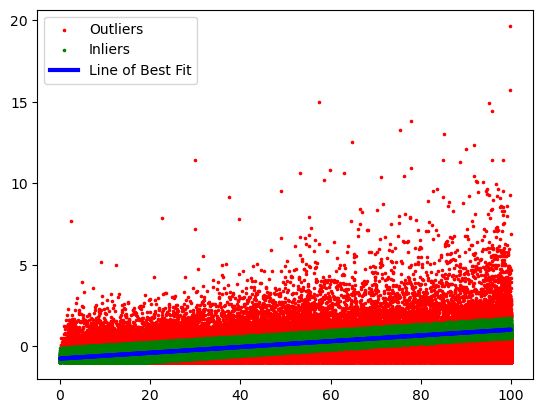

Median Model_Miss: 33.09927625790765 			Average Model_Miss: 36.39821490041172
Median Gradient_Miss: 64.49213532379451 		Average Gradient_Miss: 70.79549549448738 



In [112]:
# Actually obtaining the model.
temp_ransac = runRANSAC('Non_White_Percent', 'Lunch_Program_Elig')
final_model_ipe = runModel(['Non_White_Percent', 'Income_Poverty_Estimate'], 'Lunch_Program_Elig', temp_ransac)

The regular model appears to be doing much better than the gradient descent model, so that is the one that I will use. Given how widespread the data was, this is a significant improvement in the accuracy of predicting the values of different missing variables.

Linear regression won't really work with remote learning accessibility since that is a binary variable. Instead, I will have to use k-nearest neighbors to predict whether or not a given school district has remote learning as an option. Thankfully, I will not have to remove any outliers since there are only two possible values: 0 and 1.

In [20]:
# Creating training and testing sets to train the model on.
df_test = small_df.copy()
X_train, X_test, Y_train, Y_test = train_test_split(small_df[['Non_White_Percent', 'Income_Poverty_Estimate']], small_df['Virtual'], test_size=0.2)

# Creating Pandas DataFrames containing the varaibles that I am measuring with
# and the variable that I want to measure.
X = statsmodels.api.add_constant(df_test[['Non_White_Percent', 'Income_Poverty_Estimate']]).to_numpy()
y = df_test['Virtual'].to_numpy()

# Creating and training the k-nearest neighbors algorithm.
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

# Printing the score for the k-nearest neighbors algorithm.
score = knn.score(X_test, Y_test)
print("Mean accuracy for k-nearest neighbors:", score)

# Creating a scatter plot to compare the percentage of non-white students in a school distrcit, the
# income-poverty estimate in that school district, and that school district's access to remote learning.
pio.renderers.default = 'iframe'
fig2 = px.scatter(df_test, x="Non_White_Percent", y="Income_Poverty_Estimate", color="Virtual",
                  title="Percentage of Non-White Students and Income-Poverty Estimate vs. Remote Learning Accessibility")
fig2.show()

Mean accuracy for k-nearest neighbors: 0.8871187363834423


The accuracy for this k-nearest neighbors algorithm is really good, but I think that that is partial due to how large the sample size is.

Now we just have to find the missing values from earlier and include those in our estimates this time.

In [21]:
# Creating Pandas DataFrames for the rows with missing values for lunch program
# eligibility and remote learning accessibility.
missing_lpe_df = df_2019[df_2019['Lunch_Program_Elig'] < 0].copy()
missing_vir_df = df_2019[(df_2019['Virtual'] != 0) & (df_2019['Virtual'] != 1)].copy()

# Using the linear regression model and k-nearest neighbors algorithm to predict the likely
# values for the missing data.
new_lpe_arr = final_model_ipe.predict(missing_lpe_df[['Non_White_Percent', 'Income_Poverty_Estimate']])
new_vir_arr = knn.predict(missing_vir_df[['Non_White_Percent', 'Income_Poverty_Estimate']])

# Putting the estimated values back into the DataFrames that they were estimated from.
missing_lpe_df.loc[:, 'Lunch_Program_Elig'] = new_lpe_arr
missing_vir_df.loc[:, 'Virtual'] = new_vir_arr

missing_lpe_df = missing_lpe_df.reset_index(drop=True)
missing_vir_df = missing_vir_df.reset_index(drop=True)

final_df = df_2019.copy()
i = 0
j = 0
k = 0

# Putting all of the formerly missing values into their correct locations in the original DataFrame.
while (i < len(missing_lpe_df)) & (j < len(missing_vir_df)):
    if final_df.iloc[i, 0] == missing_lpe_df.iloc[j, 0]:
        final_df.iloc[i, 0] = missing_lpe_df.iloc[j, 5]
        j = j + 1
    if final_df.iloc[i, 0] == missing_vir_df.iloc[k, 0]:
        final_df.iloc[i, 0] = missing_vir_df.iloc[k, 4]
        k = k + 1
    i = i + 1

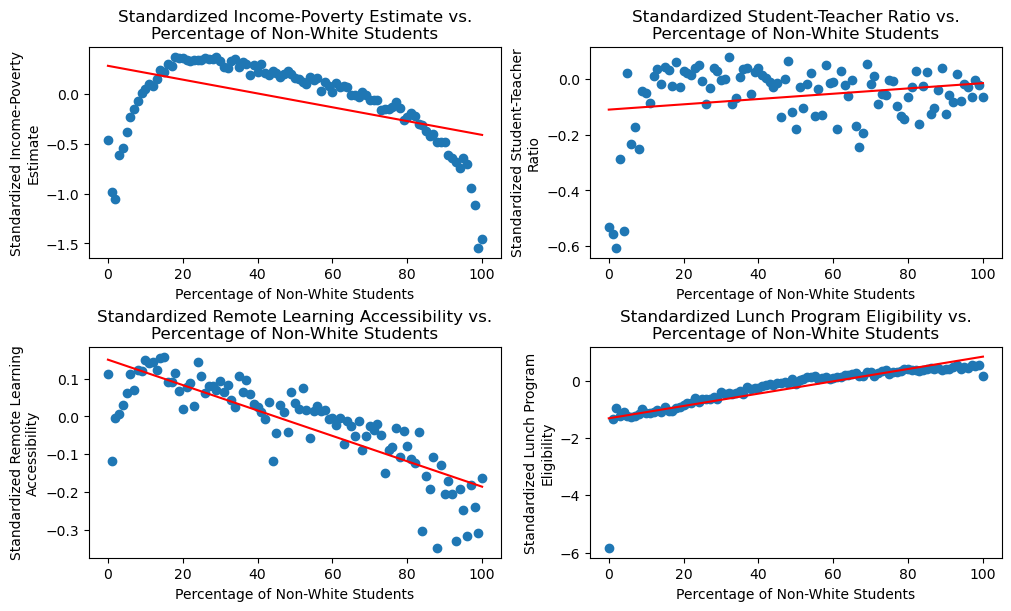

In [22]:
graph_relations(final_df)

There isn't much that changed in the graphs, but that shows that our prediction algorithms were pretty accurate. If they weren't then the relationships would have probably been way off.

In [23]:
# Actually graphing the relationships.
p_df = get_percent_df(final_df)
graph_eth_relations(p_df)

I was hoping that the extra data would remove some of the outlier spikes from the graph, but apparently that didn't happen. Thankfully, we can still get an idea of what the general trends are using these graphs.

The data here is cleaner than it was before, but it still isn't perfect. However, it does still show the same relationships that it showed when it was less refined, so that is more evidence the models worked like they should.

## Insight and Policy Decision:

This is the most important step in the data science pipeline. Without it, we would just have a bunch of data with nothing to get from it.
Based on the data we have found, we can safely say that:

1. Whiter school districts tend to have lower poverty rates and lunch program eligibility while also having greater access to virtual learning.
2. School districts with more black or Hispanic students tend to have higher poverty rates and lunch program eligibility while also having less access to virtual learning.

There is already overwhelming evidence that systemic inequality is still rampant in the United States, but being able to quantify this problem may convince some people that this is real.

If I could conduct more research, I would try to find the actual federal funding for these schools to see if this can be proven on a federal level, but unfortunately I couldn't find any database with that information on it.

If anyone says that the idea systemic inequality in the modern United States is unfounded, just show them this tutorial and point out that a computer science student with minimal knowledge of politics managed to figure it out using publicly available data.

This tutorial should also provide a glimpse into the data science pipeline, from data collection, to data processing, to exploratory analysis and data visualization, to analysis and hypothesis testing and machine learning, to the insight and policy decision.

## Data sources:

* https://data-nces.opendata.arcgis.com/datasets/nces::school-neighborhood-poverty-estimates-current
* https://data-nces.opendata.arcgis.com/datasets/nces::public-school-characteristics-2019-20